# Amazon AWS S3 Search with LlamaIndex

This example shows how to use the Python [LlamaIndex](https://www.llamaindex.ai/) library to run a text-generation request against [Cohere's](https://cohere.com/) API, then augment that request using documents stored in an Amazon AWS S3 bucket.

**Requirements:**
- You will need an access key to Cohere's API key, which you can sign up for at (https://dashboard.cohere.com/welcome/login). A free trial account will suffice, but will be limited to a small number of requests.
- After obtaining this key, store it in plain text in your home in directory in the `~/.cohere.key` file.
- You will also need an Amazon AWS account, with some documents stored in a S3 bucket.
- Store your AWS credentials in a text file at `.aws/credentials`. This file must use the following format:
  
  ```
    [default]
    aws_access_key_id = YOUR_ACCESS_KEY
    aws_secret_access_key = YOUR_SECRET_KEY
  ```

## Set up the RAG workflow environment

In [1]:
import os
from pathlib import Path
import sys

from llama_index import download_loader, ServiceContext, VectorStoreIndex
from llama_index.embeddings.cohereai import CohereEmbedding
from llama_index.llms import Cohere
from llama_index.postprocessor.cohere_rerank import CohereRerank

Set up some helper functions:

In [2]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

Make sure other necessary items are in place:

In [3]:
# Setup the environment
try:
    os.environ["COHERE_API_KEY"] = open(Path.home() / ".cohere.key", "r").read().strip()
    os.environ["CO_API_KEY"] = os.environ["COHERE_API_KEY"]
except Exception:
    sys.exit(f"Unable to read your Cohere API key. Make sure this is stored in a text file in your home directory at ~/.cohere.key\n")

# Make sure that the AWS credentials are stored in ~/.aws/credentials
try:
    aws_credentials_file = Path.home() / ".aws/credentials"
    assert aws_credentials_file.exists()
except:
    sys.exit(f"Unable to find your AWS credentials file at {aws_credentials_file}. Make sure this file exists and contains your AWS credentials.\n")

# Make sure the AWS credentials are stored in the correct format
try:
    aws_credentials = open(aws_credentials_file, "r").read().strip()
    assert aws_credentials.startswith("[default]")
    assert "aws_access_key_id" in aws_credentials
    assert "aws_secret_access_key" in aws_credentials
except Exception:
    sys.exit(f"""Unable to load AWS credentials. Make sure your ~/.aws/credentials file is in the following format:
[default]
aws_access_key_id = YOUR_ACCESS_KEY
aws_secret_access_key = YOUR_SECRET_KEY\n""")

## Start with a basic generation request without RAG augmentation

Let's start by asking the Cohere LLM a difficult, domain-specific question we don't expect it to have an answer to. A simple question like "*What is the capital of France?*" is not a good question here, because that's basic knowledge that we expect the LLM to know.

Instead, we want to ask it a question that is very domain-specific that it won't know the answer to. Let's use an obscure research project we don't expect it to know the answer to.

"*Describe the goals of the OpenNF project.*"

In [4]:
query = "Describe the goals of the OpenNF project."

## Send the generation request to Cohere

In [5]:
llm = Cohere(api_key=os.environ["COHERE_API_KEY"])
result = llm.complete(query)
print(result)

 The OpenNF project aims to create a fully open-source implementation of a Natural Language Understanding (NLU) model, similar to ChatGPT. The current iteration of the project is trained on a dataset of text from the internet up to 2021.

The project is largely divided into two components: OpenNF Model and OpenNF Toolkit. 

The OpenNF Model is a neural network built using PyTorch to leverage transfer learning from a pre-trained BERT model and fine-tuned on a more specific dataset. This allows the model to understand and generate text based on the information it has learned from its training. 

The OpenNF Toolkit, on the other hand, is a set of tools and libraries that provide users with easy access to the OpenNF model and its capabilities, allowing them to make use of the model in their own projects or applications. The toolkit also provides tools to annotate datasets, which will be used to further train and improve the OpenNF model. 

Overall, the goal of the OpenNF project is to prov

Cohere will occasionally get this right *(TODO: find a better example!)* but usually gets it wrong. The correct answer is that OpenNF is NFV+SDN networking project that focuses on state transfer in virtualized network environments.

## Ingestion: Retrieve some documents from an Amazon S3 bucket

I've added a few PDF documents related to the OpenNF project in an Amazon S3 bucket:

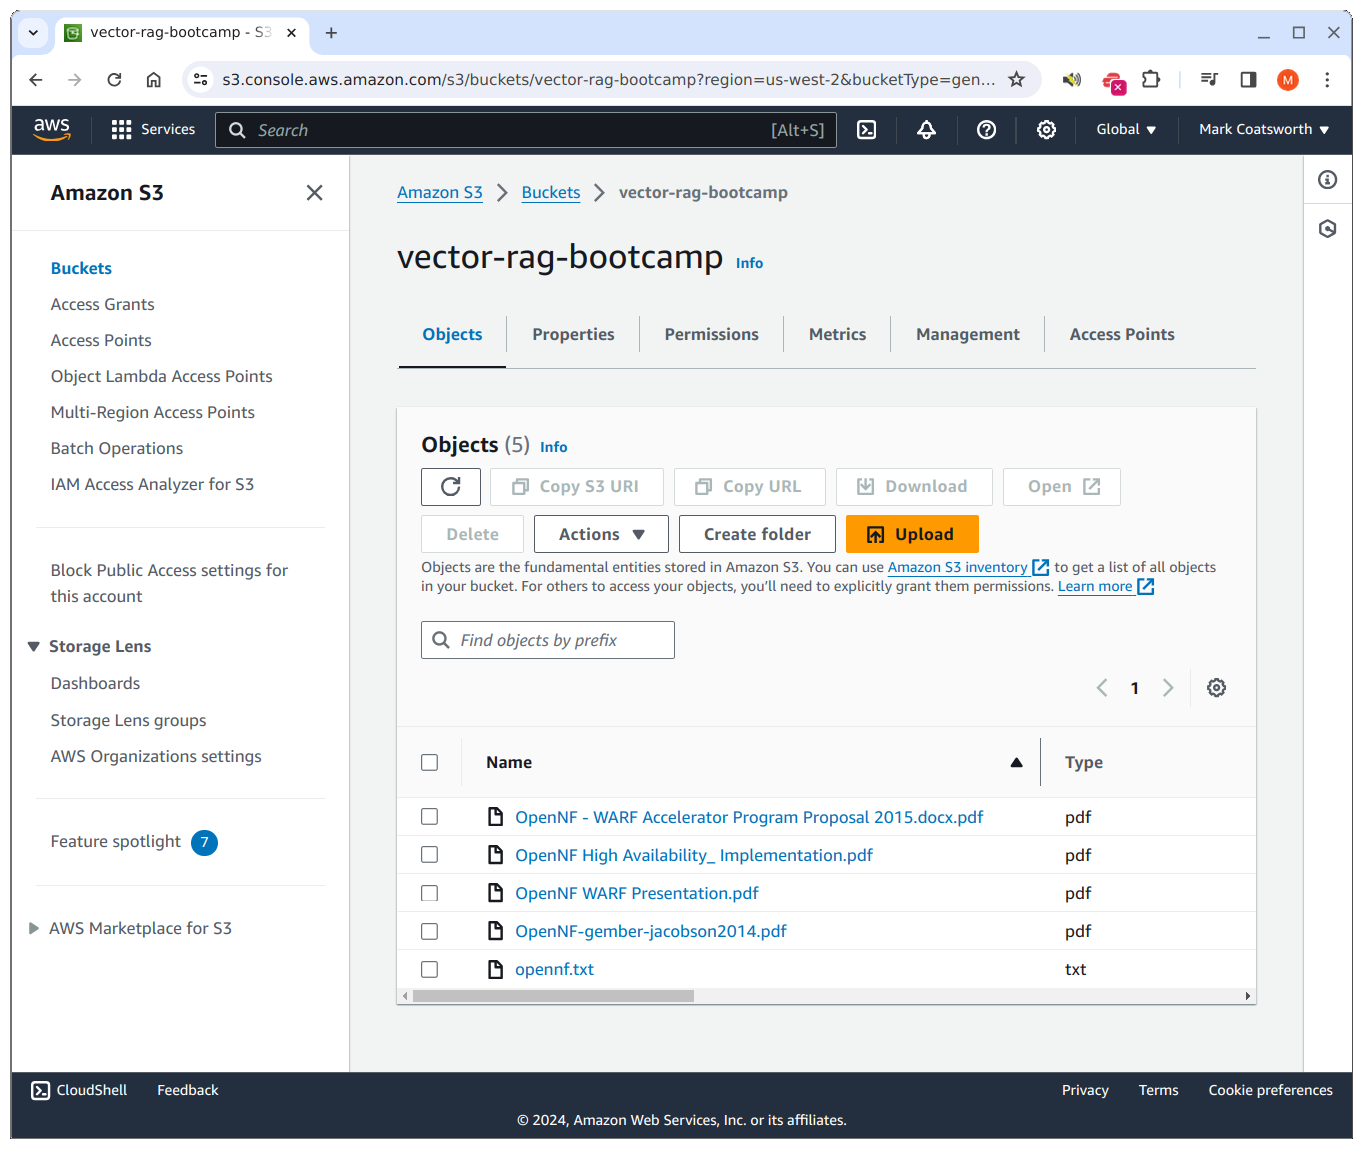

### Load these documents using S3Reader

Fortunately, there is a simple S3 utility available via [LlamaHub](https://www.llamahub.ai/), a registry of open-source data connectors that you can easily plug into any LlamaIndex application.

In [6]:
S3Reader = download_loader("S3Reader")
loader = S3Reader(bucket='vector-rag-bootcamp')
documents = loader.load_data()

## Define Embeddings Model

In [7]:
embed_model = CohereEmbedding(
    model_name="embed-english-v3.0",
    input_type="search_query"
)
service_context = ServiceContext.from_defaults(
    embed_model=embed_model,
    llm=llm
)

## Embeddings Store, Retrieval and Reranking

In [8]:
# Set up the base vector store retriever
index = VectorStoreIndex.from_documents(documents, service_context=service_context, show_progress=True)

# Retrieve the most relevant context from the vector store based on the query
search_query_retriever = index.as_retriever(service_context=service_context)
search_query_retrieved_nodes = search_query_retriever.retrieve(query)

# Use a reranker to identify the most closest match
reranker = CohereRerank()
query_engine = index.as_query_engine(
    node_postprocessors = [reranker]
)

Parsing nodes:   0%|          | 0/27 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/74 [00:00<?, ?it/s]

## Lastly, send the augmented request to Cohere

In [9]:
result = query_engine.query(query)
print(result)

The OpenNF project is a research project that started in 2012 and has filed two patents under WARF (one issued, one pending). 

It provides critical mechanisms to the SDN+NFV landscape and aims to provide a high-calibre solution to problems that are rapidly becoming evident. 

The goals of the project are to:

- Provide a way to redirect network traffic through a series of in-network devices (this is referred to as 'Chain Move')
- Improve the data exchange mechanism between systems (addressing Serialization Performance)
- Ensure the system is highly available, even when failures occur (High Availability)
- Develop a GUI (Graphic User Interface) 

The project is funded by the WARF Accelerator, which has funded three CS students since 2015 towards the development and commercialization of the OpenNF technology.
